In [21]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from bs4 import BeautifulSoup
import requests
import csv

import datetime as dt
import time

from tqdm.notebook import tqdm, trange
from multiprocessing import Pool

# Weather Data Scraper

## Code

In [23]:
# all weather stations from noaa dataset
weather_stations = pd.read_csv('isd-history.csv')
# countries of interest
country_list = ['CH', 'IN', 'ID', 'BG', 'VM', 'TH', 'BM', 'RP', 'BR', 'JA']
# weather stations filtered by relevant countries
stations_filtered = weather_stations[weather_stations['CTRY'].isin(country_list)].reset_index(drop=True)

In [24]:
url = 'https://www.ncei.noaa.gov/data/daily-summaries/access/'
r = requests.get(url)
soup = BeautifulSoup(r.text, 'html.parser')

In [25]:
a_tags = soup.find_all('a')

In [27]:
# scraping every csv link from the url
FIRST_CSV_INDEX = 5
csv_links = list(map(lambda x: x.get('href'), a_tags))
csv_links = csv_links[FIRST_CSV_INDEX:]

#dubug
og_len = len(csv_links)

In [28]:
# filtering for target countries by searching for all links that start with 
# target country codes 
COUNTRY_CODE_CUTOFF = 2
filtered_csv_links = list(filter(
    lambda x: x[0:COUNTRY_CODE_CUTOFF] in country_list, csv_links))

#debug
filtered_len = len(filtered_csv_links)
print(f'og_len: {og_len},\n' \
    f'filtered_len: {filtered_len},\n' \
    f'The filtered list is {round(100*(filtered_len/og_len), 2)}% of the original')

og_len: 119468,
filtered_len: 10489,
The filtered list is 8.78% of the original


In [29]:
len(list(filter(lambda x: x[0:2] == 'BR', filtered_csv_links)))

5989

In [386]:
links = filtered_csv_links

In [97]:
# scrape all files from links
with requests.Session() as s:    
    for link in tqdm(links): 
        r = s.get(url+link)
        with open('Weather_CSVs/'+link, 'wb') as f:
            f.write(r.content)

  0%|          | 0/4422 [00:00<?, ?it/s]

In [74]:
1.63*11000/60/60

4.980555555555555

In [31]:
pd.read_csv('Weather_CSVs/'+links[1])

,STATION,DATE,LATITUDE,LONGITUDE,ELEVATION,NAME,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES
0,CHM00050658,1951-01-01,48.05,125.883,237.0,"KESHAN, CH",0.0,",,s",NaN,NaN,-245.0,",,s",-350.0,",,s",NaN,NaN
1,CHM00050658,1951-01-02,48.05,125.883,237.0,"KESHAN, CH",0.0,",,s",NaN,NaN,-260.0,",,s",-396.0,",,s",-350.0,",,s"
2,CHM00050658,1951-01-03,48.05,125.883,237.0,"KESHAN, CH",0.0,",,s",NaN,NaN,-265.0,",,s",-420.0,",,s",-363.0,",,s"
3,CHM00050658,1951-01-04,48.05,125.883,237.0,"KESHAN, CH",0.0,",,s",NaN,NaN,-265.0,",,s",-410.0,",,s",-359.0,",,s"
4,CHM00050658,1951-01-05,48.05,125.883,237.0,"KESHAN, CH",0.0,",,s",NaN,NaN,-253.0,",,s",-412.0,",,s",-349.0,",,s"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25979,CHM00050658,2022-02-25,48.05,125.883,237.0,"KESHAN, CH",0.0,",,S",NaN,NaN,-63.0,",,S",-164.0,",,S",-93.0,"H,,S"
25980,CHM00050658,2022-02-26,48.05,125.883,237.0,"KESHAN, CH",0.0,",,S",NaN,NaN,-33.0,",,S",-155.0,",,S",-74.0,"H,,S"
25981,CHM00050658,2022-02-27,48.05,125.883,237.0,"KESHAN, CH",0.0,",,S",NaN,NaN,-33.0,",,S",-123.0,",,S",-93.0,"H,,S"
25982,CHM00050658,2022-02-28,48.05,125.883,237.0,"KESHAN, CH",0.0,",,S",NaN,NaN,-33.0,",,S",-128.0,",,S",-82.0,"H,,S"


# Database

In [5]:
try:
    import pyodbc
except:
    %pip install pyodbc
    import pyodbc

In [18]:
server = 'rice-machine.database.windows.net'
database = 'Rice_Price_Prediction'
username = 'Teo'
password = 'D1n0saursrul31?'
driver= '{ODBC Driver 13 for SQL Server}'

cnxn = pyodbc.connect(
    'DRIVER=' + driver \
    + ';PORT=1433;SERVER=' + server \
    + ';PORT=1443;DATABASE=' + database \
    + ';UID=' + username \
    + ';PWD=' + password)
cursor = cnxn.cursor()



Error: ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib 'ODBC Driver 13 for SQL Server' : file not found (0) (SQLDriverConnect)")

In [10]:
drivers = [item for item in pyodbc.drivers()]
drivers

[]

# Station Clustering 

## Sandbox

### Condense Each CSV into a Row

In [519]:
# takes in csv links converts to dataframe and takes the mean grouping by 
# station id
rows = []
#links_subset = links[5000:]
for link in tqdm(links): 
    try:
        station = pd.read_csv(f'Weather_CSVs/{link}')
    except:
        print(link + ' does not exist!')
        continue
    row = station.groupby('STATION').mean()
    
    # add number of years the station has been operation to data 
    years = station['DATE'].apply(lambda x: [int(v) for v in x.split('-')][0])
    row['YEAR_RANGE'] = years.iloc[-1] - years.iloc[0]
    rows.append(row)


  0%|          | 0/10489 [00:00<?, ?it/s]

IN011171400.csv does not exist!


/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17,19,21,23,27,31,33,37,45,47,49,53,55,57,59,61,67) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (9,11,17,21,23,25,27,29,31,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17,19,21,23,27,31,33,39,47,49,53,55,57

VM000048900.csv does not exist!
VMM00048806.csv does not exist!
VMM00048808.csv does not exist!
VMM00048820.csv does not exist!
VMM00048825.csv does not exist!
VMM00048826.csv does not exist!
VMM00048830.csv does not exist!
VMM00048840.csv does not exist!
VMM00048845.csv does not exist!
VMM00048848.csv does not exist!
VMM00048855.csv does not exist!
VMM00048887.csv does not exist!
VMM00048914.csv does not exist!
VMM00048917.csv does not exist!
VMW00040001.csv does not exist!
VMW00041003.csv does not exist!
VMW00041004.csv does not exist!
VMW00041005.csv does not exist!
VMW00041006.csv does not exist!
VMW00041007.csv does not exist!
VMW00041008.csv does not exist!
VMW00041009.csv does not exist!
VMW00041010.csv does not exist!
VMW00041011.csv does not exist!
VMW00041013.csv does not exist!
VMW00041014.csv does not exist!
VMW00041015.csv does not exist!
VMW00041016.csv does not exist!
VMW00041021.csv does not exist!
VMW00041022.csv does not exist!
VMW00041023.csv does not exist!
VMW00041

In [520]:
data = pd.concat(rows)
countries = list(map(lambda x: x[0:2], data.index))
data = data.assign(CTRY=countries)
data

,LATITUDE,LONGITUDE,ELEVATION,PRCP,TMAX,TMIN,TAVG,YEAR_RANGE,MDPR,SNWD,...,WV20,PSUN,TSUN,WESD,WT06,WT21,WT22,WT17,WV01,CTRY
STATION,,,,,,,,,,,,,,,,,,,,,
BGM00041859,25.73300,89.23300,34.0,47.057642,298.566145,201.216172,247.716676,40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG
BGM00041883,24.85000,89.36700,20.0,35.132441,308.904424,209.534170,255.105991,40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG
BGM00041891,24.96300,91.86700,15.2,79.459159,304.077788,203.924900,248.382173,78,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG
BGM00041907,24.15300,89.04900,13.7,31.317428,312.525578,202.173003,252.073720,40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG
BGM00041923,23.77900,90.38300,7.3,41.438111,309.779176,217.571972,261.245887,77,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THW00041018,17.38333,102.80000,178.0,52.386446,324.442994,215.315413,269.964093,79,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TH
THW00041019,14.93333,102.08333,222.2,27.328515,317.756899,227.194481,NaN,2,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TH
THW00041020,17.38333,104.65000,176.2,48.819499,320.903947,210.936842,NaN,2,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TH


#### Country Distribution Visualization

<AxesSubplot:>

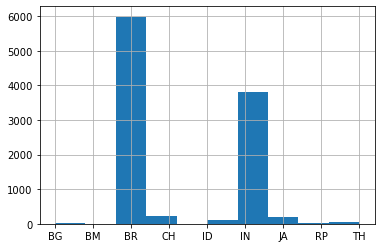

In [521]:
data['CTRY'].hist()

### Visualize Missing Data

In [522]:
import missingno as msno

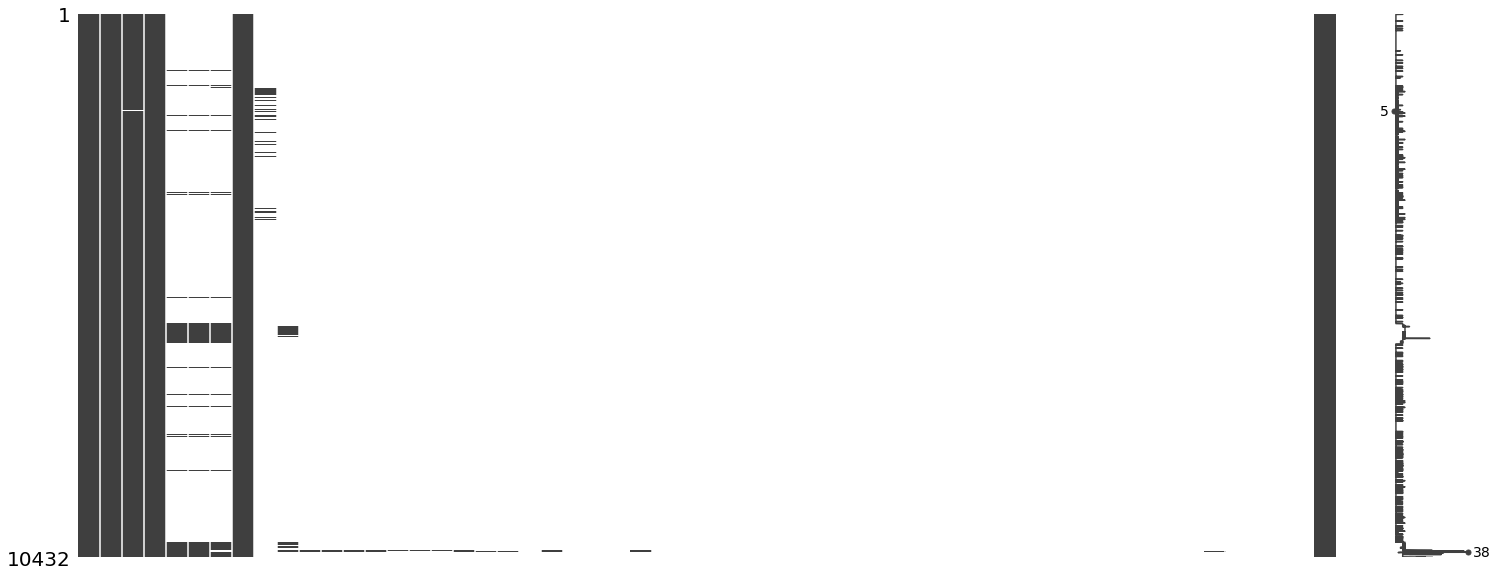

In [523]:
msno.matrix(data)
plt.show()

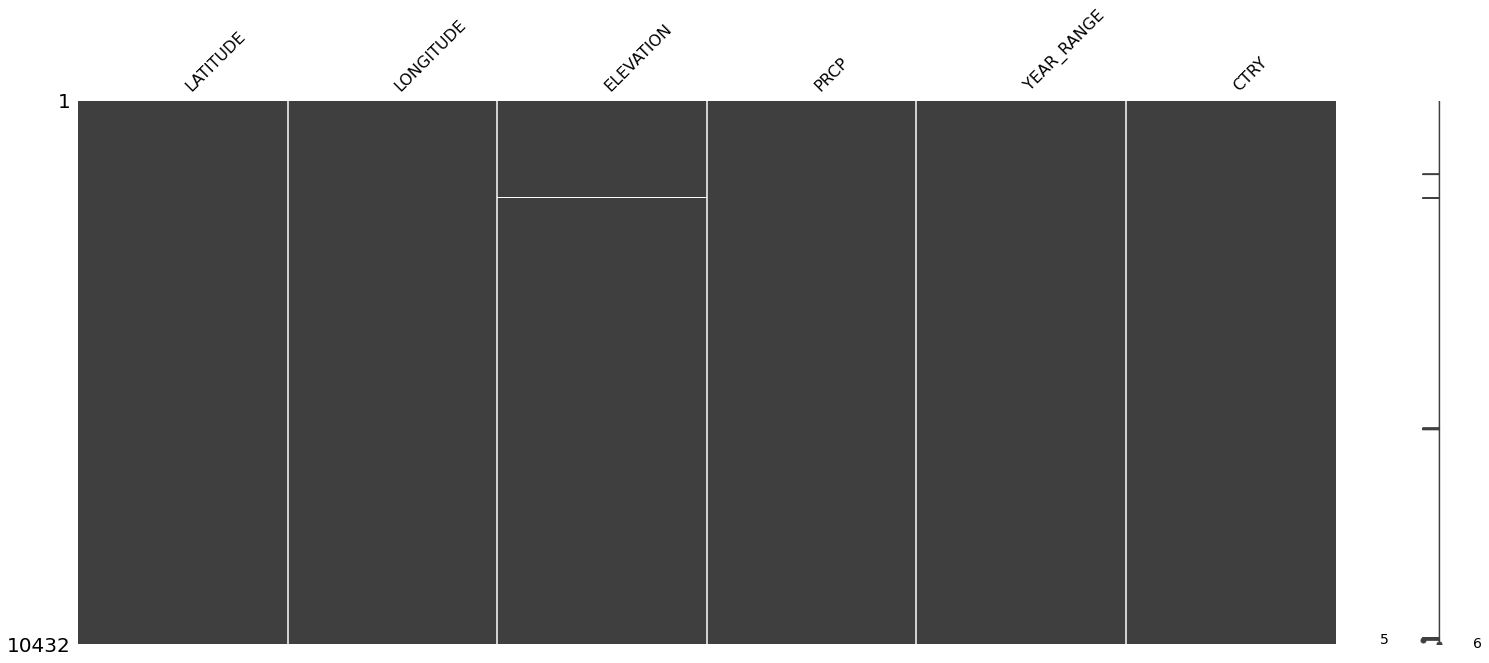

In [524]:
# Remove Inconsistent Variables
reduced_data = data.get(
    ['LATITUDE', 'LONGITUDE', 'ELEVATION', 'PRCP', 'YEAR_RANGE', 'CTRY'])
msno.matrix(reduced_data)
plt.show()

### Clustering

In [525]:
from sklearn.cluster import SpectralClustering

In [532]:
# removing brazil from the data to reduce confounders 
df = data[data['CTRY'] != 'BR']
#df = data

preprocessed_data = df.fillna(0).reset_index(drop=True) \
    .drop(['YEAR_RANGE', 'CTRY'], axis=1)
preprocessed_data = preprocessed_data.div(
    preprocessed_data.sum(axis=1), axis=0)
preprocessed_data

,LATITUDE,LONGITUDE,ELEVATION,PRCP,TMAX,TMIN,TAVG,MDPR,SNWD,SNOW,...,WT14,WV20,PSUN,TSUN,WESD,WT06,WT21,WT22,WT17,WV01
0,0.027273,0.094574,0.036035,0.049874,0.316438,0.213261,0.262544,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.026355,0.094779,0.021211,0.037260,0.327613,0.222225,0.270556,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.025792,0.094916,0.015705,0.082097,0.314171,0.210694,0.256627,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.026112,0.096270,0.014811,0.033857,0.337869,0.218567,0.272515,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.024991,0.094990,0.007672,0.043550,0.325570,0.228663,0.274563,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4438,0.005769,0.034116,0.059072,0.017385,0.107671,0.071455,0.089591,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4439,0.016276,0.111263,0.242181,0.029786,0.346330,0.247624,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4440,0.019667,0.118397,0.199345,0.055232,0.363057,0.238645,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4441,0.005691,0.045327,0.008211,0.013472,0.139346,0.110385,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [579]:
NUM_CLUSTERS = 20
RANDOM_SATAE = 0
ASSIGN_LABLES_METHOD = 'discretize'

clustering = SpectralClustering(
    n_clusters=NUM_CLUSTERS, assign_labels=ASSIGN_LABLES_METHOD, 
    random_state=RANDOM_SATAE
    ).fit(preprocessed_data)
data_clustered = df.assign(CLUSTER = clustering.labels_)
data_clustered

,LATITUDE,LONGITUDE,ELEVATION,PRCP,TMAX,TMIN,TAVG,YEAR_RANGE,MDPR,SNWD,...,PSUN,TSUN,WESD,WT06,WT21,WT22,WT17,WV01,CTRY,CLUSTER
STATION,,,,,,,,,,,,,,,,,,,,,
BGM00041859,25.73300,89.23300,34.0,47.057642,298.566145,201.216172,247.716676,40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG,1
BGM00041883,24.85000,89.36700,20.0,35.132441,308.904424,209.534170,255.105991,40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG,1
BGM00041891,24.96300,91.86700,15.2,79.459159,304.077788,203.924900,248.382173,78,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG,1
BGM00041907,24.15300,89.04900,13.7,31.317428,312.525578,202.173003,252.073720,40,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG,1
BGM00041923,23.77900,90.38300,7.3,41.438111,309.779176,217.571972,261.245887,77,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BG,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
THW00041018,17.38333,102.80000,178.0,52.386446,324.442994,215.315413,269.964093,79,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TH,7
THW00041019,14.93333,102.08333,222.2,27.328515,317.756899,227.194481,NaN,2,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TH,10
THW00041020,17.38333,104.65000,176.2,48.819499,320.903947,210.936842,NaN,2,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TH,10


#### Plotting Weather Stations using Longitude and Lattitude -- Separating Clusters by Color

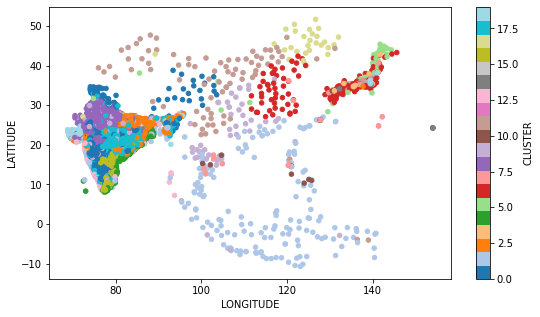

In [580]:
fig = plt.figure(figsize = (9,5))
ax = plt.axes()
data_clustered.plot.scatter(
    x='LONGITUDE', y='LATITUDE', ax=ax, colormap='tab20', c='CLUSTER')
plt.show()

In [535]:
len(data_clustered)

4443

#### Countries per Cluster (CTRY) & Datapoints per Cluster (FREQ) Visualization

the bar chart below shows the following:
1) the number of countries per cluster *normalized (blue)
2) the number of rows corresponding to each cluster *normalized (orange)

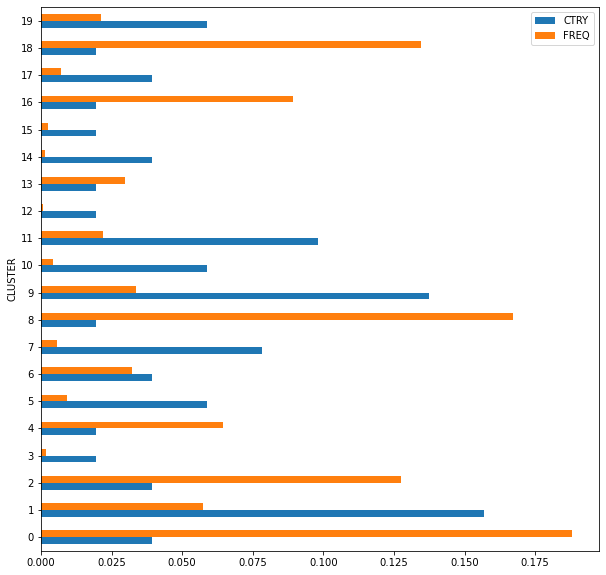

In [576]:
cluster_df = data_clustered.groupby('CLUSTER').nunique().get(['CTRY']).assign(
    FREQ = data_clustered.groupby('CLUSTER').count()['CTRY']
)
cluster_df = cluster_df.div(
    cluster_df.sum(axis=0), axis=1)

cluster_df.plot(kind='barh', figsize=(10,10), stacked=False)
plt.show()

In general, clusters which capture more data are spread across fewer countries.

### Merge the Data by Cluster

In [586]:
weather_data_by_cluster = []
for cluster_i in tqdm(range(NUM_CLUSTERS)):
    stations = data_clustered[data_clustered['CLUSTER'] == cluster_i].index
    data = []
    for station in tqdm(stations):
        data.append(pd.read_csv(f'Weather_CSVs/{station}.csv'))
    weather_data_by_cluster.append(data)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/836 [00:00<?, ?it/s]

  0%|          | 0/255 [00:00<?, ?it/s]

  0%|          | 0/566 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/287 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/143 [00:00<?, ?it/s]

/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


  0%|          | 0/26 [00:00<?, ?it/s]

/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (9,11,17,21,23,25,27,29,31,33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


  0%|          | 0/743 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17,19,21,23,27,31,33,37,45,47,49,53,55,57,59,61,67) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17,19,21,23,27,31,33,39,47,49,53,55,57,59,65,67,69) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/teo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (17,19,21,23,27,31,33,39,45,47,53,55,57,59,61,65,69,71) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/397 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/598 [00:00<?, ?it/s]

  0%|          | 0/94 [00:00<?, ?it/s]